# Лабораторная работа №6
## Задача о рюкзаке

**Задача**: решить задачу о рюкзаке с одним типом предмета и проанализировать, как меняется решение, когда в задачу вводится новый тип предмета в количестве 1 штуки.

$$ \sum_{i=1}^{n}v_ix_i \rightarrow max $$

$$ \sum_{i=1}^{n}w_ix_i \leq W, x_i \in X_i $$

Реализовать алгоритм решения с помощью библиотеки Pyomo и собственный жадный алгоритм для решения данной задачи, создать универсальный формат задания задачи.

In [13]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import networkx as nx
from functools import reduce
import pandas as pd
import shutil
import sys
import numpy as np
import math
import json
import os.path
from pyomo.environ import *
from pyomo.gdp import *
from pyomo.contrib.latex_printer import latex_printer

In [14]:
# Запись задачи в JSON формат
def WriteJson(dictionary: dict, name = "task.json"):
    with open(name, 'w') as f:
        json.dump(dictionary, f)

# Чтение задачи из JSON формата
def ReadJson(name = "task.json") -> dict:
    with open(name, 'r') as f:
        m = json.loads(f.read())
        return m

## Реализация в Pyomo

In [15]:
#Создание метода решения
def BackpackMachines(ITEMS, MAX_WEIGHT):

    m = ConcreteModel()

    m.J = Set(initialize=ITEMS.keys())
    
    m.count = Var(m.J, domain=NonNegativeIntegers)
    m.sum_cost = Var(domain=NonNegativeReals)
    
    m.OBJ = Objective(expr = m.sum_cost, sense = maximize)

    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.count[j] <= ITEMS[j]["count"])
    
    m.c2 = Constraint(rule=lambda m:
            sum(m.count[j] * ITEMS[j]["weight"] for j in m.J) <= MAX_WEIGHT)
    
    m.c3 = Constraint(rule=lambda m:
            sum(m.count[j] * ITEMS[j]["cost"] for j in m.J) == m.sum_cost)

#     m.display()
    solver = SolverFactory("bonmin", executable=r"..\solvers\ampl.mswin64\bonmin.exe", tee=True)
    solver.solve(m)

    DISTRIBUTIONS = {}
    
    for i in ITEMS.keys():
        DISTRIBUTIONS[i] = m.count[i]()

    return DISTRIBUTIONS, m.OBJ()

## Жадный алгоритм $O(k \cdot \log(k))$

Алгоритм:

    1. Создаём массив пар <Удельная стоимость, индекс> предметов.
    2. Сортируем по удельной стоимости в убывающем порядке
    3. Для каждого элемента из массива:
        3.1. Считаем количество i'ого предмета, которое можем положить
        3.2. К общей ценности прибавляем ценность i'ых предметов, которые кладём
        3.3. Обновляем вес, который остался нам доступен
    4. Возвращаем результат

In [16]:
def Solve(ITEMS, MAX_WEIGHT):
    
    mas = [(ITEMS[i]["cost"] / ITEMS[i]["weight"], i) for i in ITEMS.keys()]
    
    mas.sort(key = lambda x: x[0], reverse = True)
    
    DISTRIBUTIONS = {}
    score = 0
    
    for cw, i in mas:
        x = min(math.floor(MAX_WEIGHT / ITEMS[i]["weight"]), ITEMS[i]["count"])
        score += x * ITEMS[i]["cost"]
        MAX_WEIGHT -= x * ITEMS[i]["weight"]
        DISTRIBUTIONS[i] = x
    
    return DISTRIBUTIONS, score

In [17]:
def Test(name, verbose = False):
    DATA = ReadJson(name=name)

    #Задание словаря работ
    ITEMS = DATA["ITEMS"]
    MAX_WEIGHT = DATA["MAX_WEIGHT"]

    DISTRIBUTIONS1, score1 = BackpackMachines(ITEMS, MAX_WEIGHT)
    DISTRIBUTIONS2, score2 = Solve(ITEMS.copy(), MAX_WEIGHT)

    if not verbose:
        fig, ax = plt.subplots(1, 2, figsize=(15,7))
        fig.suptitle(f"{name}\nBest: {score1}\nGreedy: {score2}")
    
        ax[0].bar(ITEMS.keys(), [DISTRIBUTIONS1[i] for i in ITEMS.keys()])
        ax[1].bar(ITEMS.keys(), [DISTRIBUTIONS2[i] for i in ITEMS.keys()])
        ax[0].set(yticks=range(0, max(ITEMS[i]["count"] for i in ITEMS) + 1, 1))
        ax[1].set(yticks=range(0, max(ITEMS[i]["count"] for i in ITEMS) + 1, 1))
        ax[0].grid()
        ax[1].grid()
    
    return score1, score2

In [18]:
df = pd.DataFrame(columns=["P2_weight", "Score", "Greedy score", "Delta"])
i = 0
for p2_weight in range(1, 21):
    print(f"[{i}] Solved...")
    DATA = {
        "ITEMS" : {
            "P1": {"count": 5, "weight": 1, "cost": 1},
            "P2": {"count": 1, "weight": p2_weight, "cost": 8},
        },
        "MAX_WEIGHT": 11.5
    }

    WriteJson(DATA, "task1.json")
    s1, s2 = Test("task1.json", verbose=True)

    df.loc[i] = [p2_weight, s1, s2, abs(s1 - s2)]
    i += 1

[0] Solved...
[1] Solved...
[2] Solved...
[3] Solved...
[4] Solved...
[5] Solved...
[6] Solved...
[7] Solved...
[8] Solved...
[9] Solved...
[10] Solved...
[11] Solved...
[12] Solved...
[13] Solved...
[14] Solved...
[15] Solved...
[16] Solved...
[17] Solved...
[18] Solved...
[19] Solved...


In [19]:
df

,P2_weight,Score,Greedy score,Delta
0,1.0,13.0,13.0,0.0
1,2.0,13.0,13.0,0.0
2,3.0,13.0,13.0,0.0
3,4.0,13.0,13.0,0.0
4,5.0,13.0,13.0,0.0
5,6.0,13.0,13.0,0.0
6,7.0,12.0,12.0,0.0
7,8.0,11.0,5.0,6.0
8,9.0,10.0,5.0,5.0
9,10.0,9.0,5.0,4.0


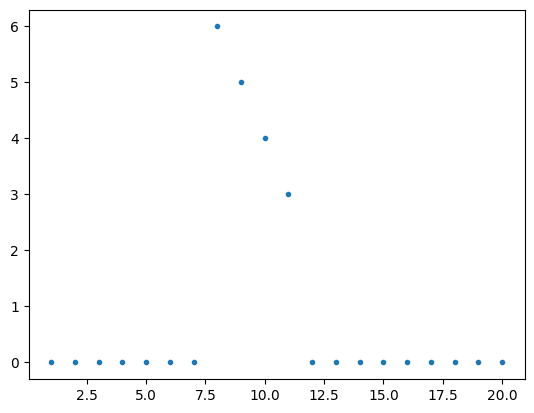

In [20]:
plt.plot(df["P2_weight"], df["Delta"], '.')
plt.show()

(52.0, 51)

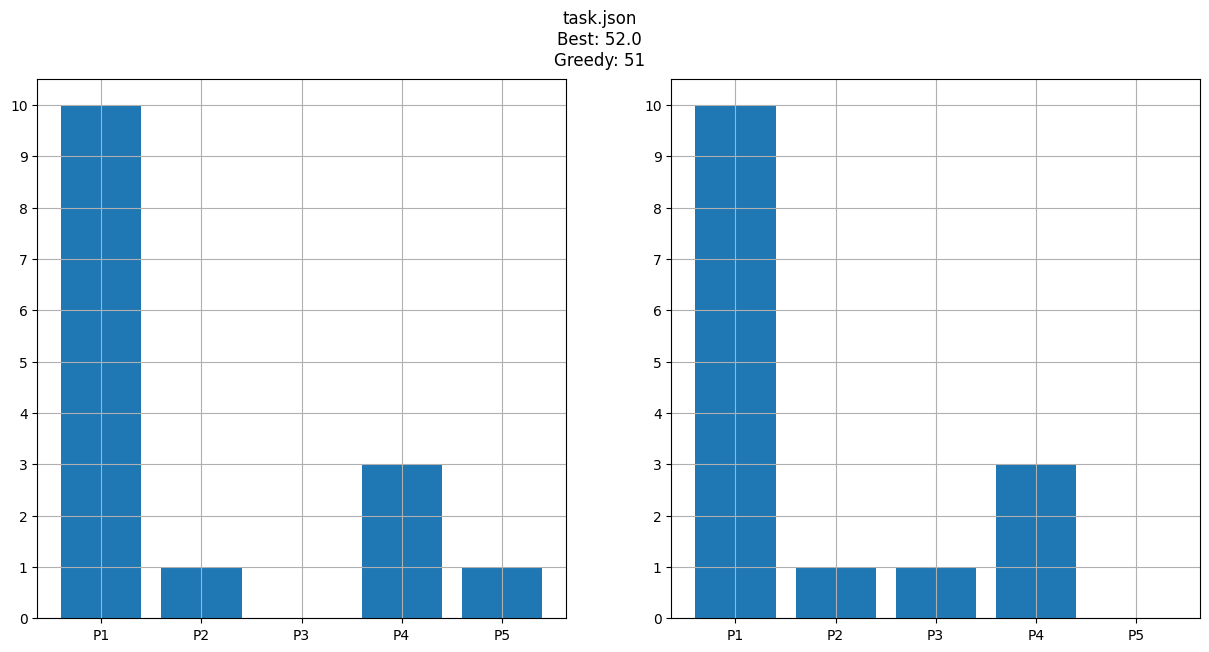

In [21]:
Test("task.json")

## Аналитическое решение

### 1. Случай с одним типом

Для первой ситуации, когда мы имеем предметы всего одного типа:

$$ v_1x_1 \rightarrow max $$
$$ w_1x_1 \leq W $$

Очевидно, что чем больше мы возьмём предметов, тем будет лучше, так как все предметы идентичны.
Максимум, который мы можем взять в соответствии с ограничением на суммарный вес: 

$$ \left\lfloor \frac{W}{w_1} \right\rfloor $$

Следовательно добавив ограничение на количество доступных предметов имеем:

$$ x_1 = \min\left(\left\lfloor \frac{W}{w_1} \right\rfloor, X_1\right) $$

Тогда итоговая ценность будет следующая:

$$ f(x_1) = v_1 \cdot \min\left(\left\lfloor \frac{W}{w_1} \right\rfloor, X_1\right) $$

### 2. Случай с двумя типами

Для второй ситуации задача будет выглядеть так:

$$ v_1x_1 + v_2x_2 \rightarrow max $$
$$ w_1x_1 + w_2x_2 \leq W $$

Теперь, так как предмет второго типа в количестве всего 1 штуки, то у нас есть два возможных исхода:
* Берем второй предмет, а остальное дозаполняем предметами 1ого типа
* Берем предметы только первого типа

Во втором случае ситуация будет аналогична предыдущей:

$$ f_1(x_1, 0) = v_1 \cdot \min\left(\left\lfloor \frac{W}{w_1} \right\rfloor, X_1\right) $$

Первый случай немного сложнее:

$$ x_2 = \min\left(\left\lfloor \frac{W}{w_2} \right\rfloor, 1\right) $$

$$ x_1 = \min\left(\left\lfloor \frac{W - w_2\min\left(\left\lfloor \frac{W}{w_2} \right\rfloor, 1\right)}{w_1} \right\rfloor, X_1\right) $$

$$ f_2(x_1, x_2) = v_1 \cdot \min\left(\left\lfloor \frac{W - w_2\min\left(\left\lfloor \frac{W}{w_2} \right\rfloor, 1\right)}{w_1} \right\rfloor, X_1\right) + v_2 \cdot \min\left(\left\lfloor \frac{W}{w_2} \right\rfloor, 1\right)$$

Таким образом нам остается выбрать максимум из этих решений:

$$ f = \max(f_1(x_1, 0), f_2(x_1, x_2))$$

### 3. Анализ

Теперь проанализируем, что происходит с ценой при изменении тех или иных параметров, ориентируясь в первую очередь на вес предмета второго типа.

В первую очередь нас интересует следующие выражение:

$$ \min\left(\left\lfloor \frac{W}{w_2} \right\rfloor, 1\right) $$

Оно определяет, можем ли мы вообще взять предмет второго типа, учитывая ограничения. Очевидно, что особой точкой является $w_2 = W$. Таким образом данное выражение определяет будет ли стоимость второго предмета включена в $f_2$ (при $w_2 \leq W$) или нет. Это означает, что изменение $v_2$ приводит к изменению графика ценности от $w_2$ только в области $w_2 \in [0; W]$ при условии, что $f_2 > f_1$, причем $v_2$ отвечает лишь за высоту графика в этой области. 

Что происходит с графиком в области $w_2 \in (W; +\infty)$? Уравнение для $f_2$ вырождается в следующее выражение:

$$ f_2(x_1, x_2) =  v_1 \min\left(\left\lfloor \frac{W}{w_1} \right\rfloor, X_1\right) $$

Это выражение аналогично $f_1$, а значит максимум для $f$ можно убрать и в области $w_2 \in (W; +\infty)$ наше оптимальное решение является горизонтальной прямой, лучём. Что же происходит в области $w_2 \in [0; W]$? В ней $f_2$ вырождается:

$$ f_2(x_1, x_2) = v_1 \cdot \min\left(\left\lfloor \frac{W - w_2}{w_1} \right\rfloor, X_1\right) + v_2 $$

Пусть $n = \left\lfloor\frac{W - w_2}{w_1}\right\rfloor$. Тогда $w_2 = W - n \cdot w_1 - \epsilon$. Получается, что особые точки $w_2$ будут: $W, W-w_1, W-2w_1, W-3w_1, \dots, W-nw_1, \dots$. Чем больше n (w_2), тем меньше предметов первого типа мы сможем взять. А именно количество этих особых точек не более $\left\lfloor\frac{W}{w_1}\right\rfloor + 1$.

При стремлении веса второго предмета к нулю $f_2$ вырождается в $f_1$, но с дополнительным слагаемым $v_2$, что по сути даёт нам максимальную ценность, так, как второй предмет мы берем "бесплатно". При постепенном увеличении веса $w_2$ мы можем положить всё меньше предметов первого типа, но мы оставляем второй до тех пор, пока его ценности достаточно. В определенный момент мы либо не сможем взять его по весу, либо будет выгоднее брать максимально возможное количество предметов первого типа.

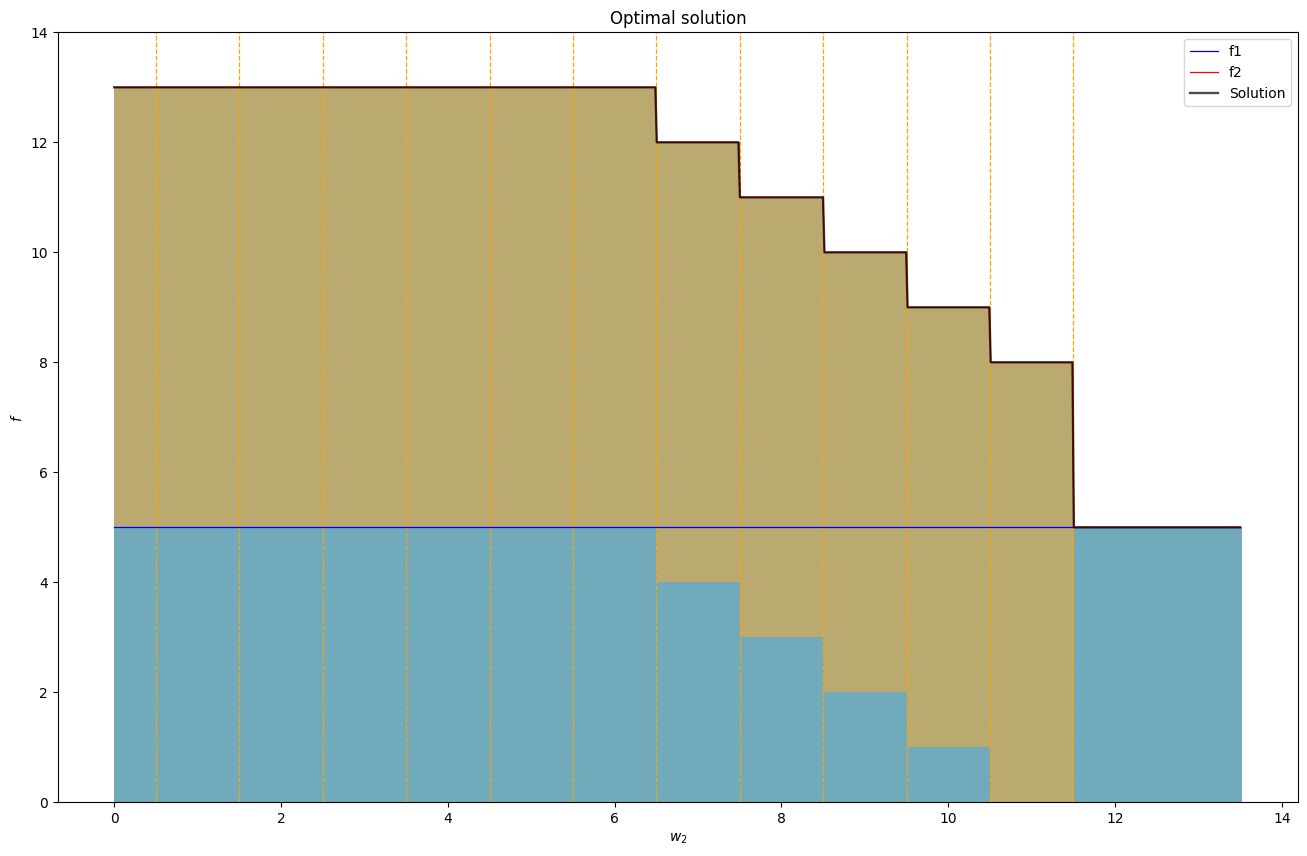

In [22]:
def calc1(w2, **kwargs):
    v1 = kwargs["v1"]
    v2 = kwargs["v2"]
    w1 = np.full_like(w2, kwargs["w1"])
    X1 = kwargs["X1"]
    W = kwargs["W"]
    
    f1 = v1 * np.minimum(np.floor(W / w1), X1)
    f2 = v1 * np.minimum(np.floor((W - w2*np.minimum(np.floor(W / w2), 1)) / w1), X1) + v2 * np.minimum(np.floor(W / w2), 1)

    x1 = (f1 >= f2) * np.minimum(np.floor(W / w1), X1) + (f1 < f2) * np.minimum(np.floor((W - w2*np.minimum(np.floor(W / w2), 1)) / w1), X1)
    x2 = (f1 < f2) * np.minimum(np.floor(W / w2), 1)
    return f1, f2, np.maximum(f1, f2), x1, x2

def draw_example(params, calc, ax, title):
    xmin, xmax = 0.00001, params["W"]+2*params["w1"]
    step = 800
    X = np.linspace(xmin, xmax, step)
    f1, f2, Y, x1, x2 = calc(X, **params)
    ymin, ymax = np.min([f1,f2,Y]), np.max([f1,f2,Y])

    ax.set_xlabel('$w_2$')
    ax.set_ylabel('$f$')
    ax.set_ylim([0, ymax+1])
    
    
    ax.vlines(
        x=[params["W"] - i*params["w1"] for i in range(int(params["W"]//params["w1"]) + 1)], 
        ymin=0, ymax=ymax+1, lw=0.9,
        color='orange', linestyles='dashed'
    )
    ax.plot(X, f1, lw=0.9, color='blue' , label="f1")
    ax.plot(X, f2, lw=0.9, color='red'  , label="f2")
    ax.plot(X, Y , lw=1.7, color='black', label="Solution", alpha=0.7)
    ax.legend(loc='best')
    ax.set_title(title)

    for i, x in enumerate(X):
        for y in range(int(x1[i])):
            width, height = (xmax - xmin) / step, params["v1"]
            ax.add_patch(plt.Rectangle((x, y*height), width, height, facecolor="#70AABB"))

        for y in range(int(x2[i])):
            width, height = (xmax - xmin) / step, params["v2"]
            rec = plt.Rectangle((x, x1[i]*params["v1"]), width, height, facecolor="#BBAA70")
            ax.add_patch(rec)

params = {
    "v1": 1, 
    "v2": 8,
    "w1": 1,
    "X1": 5,
    "W": 11.5,
}

_, ax = plt.subplots(1, 1, figsize=(16,10))
draw_example(params, calc1, ax, "Optimal solution")
plt.show()

Теперь проанализируем жадный алгоритм. Он основан на выборе того предмета, чья удельная стоимость больше, и так продолжается до тех пор, пока предмет не закончится, после чего проиходит переход к следующему предмету. Как это можно описать математически для нашей задачи?

Так как у нас всего два типа предмета, то мы можем применить ступенчатую функцию Хевисайда:

$$\theta(x) = \begin{cases} 1, x \geq 0 \\ 0, x < 0 \end{cases}$$
    
Выражение $\theta(\frac{v_1}{w_1} - \frac{v_2}{w_2})$ будет давать 1, если удельная стоимость первого предмета выше, иначе будет 0. Это будет нашей реализацией сортировки для двух элементов.

Теперь мы хотим получить нашу итоговую ценность и это будет выглядеть следующим образом:

$$x_1 = \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right) \min\left(\left\lfloor \frac{W}{w_1} \right\rfloor, X_1\right) +
\left( 1 - \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right)\right) \min\left(\left\lfloor \frac{W - w_2 \cdot x_2}{w_1} \right\rfloor, X_1\right)$$

$$x_2 = \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right) \min\left(\left\lfloor \frac{W - w_1 \cdot x_1}{w_2} \right\rfloor, 1\right) +
\left( 1 - \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right)\right) \min\left(\left\lfloor \frac{W}{w_2} \right\rfloor, 1\right)$$

Как можно заметить, у нас получается рекурсивная зависимость выражений $x_1$ и $x_2$ друг от друга, чтобы предотвратить это изменим смысл переменных, пускай $x_1$ будет не количеством предметов первого типа, который мы кладем, а количеством наилучшего по удельной стоимости предмета, а $x_2$ - следующим.

$$x_1 = \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right) \min\left(\left\lfloor \frac{W}{w_1} \right\rfloor, X_1\right) +
\left( 1 - \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right)\right) \min\left(\left\lfloor \frac{W}{w_2} \right\rfloor, 1\right)$$

$$x_2 = \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right) \min\left(\left\lfloor \frac{W - w_1 \cdot x_1}{w_2} \right\rfloor, 1\right) +
\left( 1 - \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right)\right) \min\left(\left\lfloor \frac{W - w_2 \cdot x_1}{w_1} \right\rfloor, X_1\right)$$

Итоговая ценность рюкзака будет следующей:

$$ f(x_1, x_2) = \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right) (v_1 \cdot x_1 + v_2 \cdot x_2) + 
\left(1 - \theta\left(\frac{v_1}{w_1} - \frac{v_2}{w_2}\right)\right) (v_2 \cdot x_1 + v_1 \cdot x_2)$$

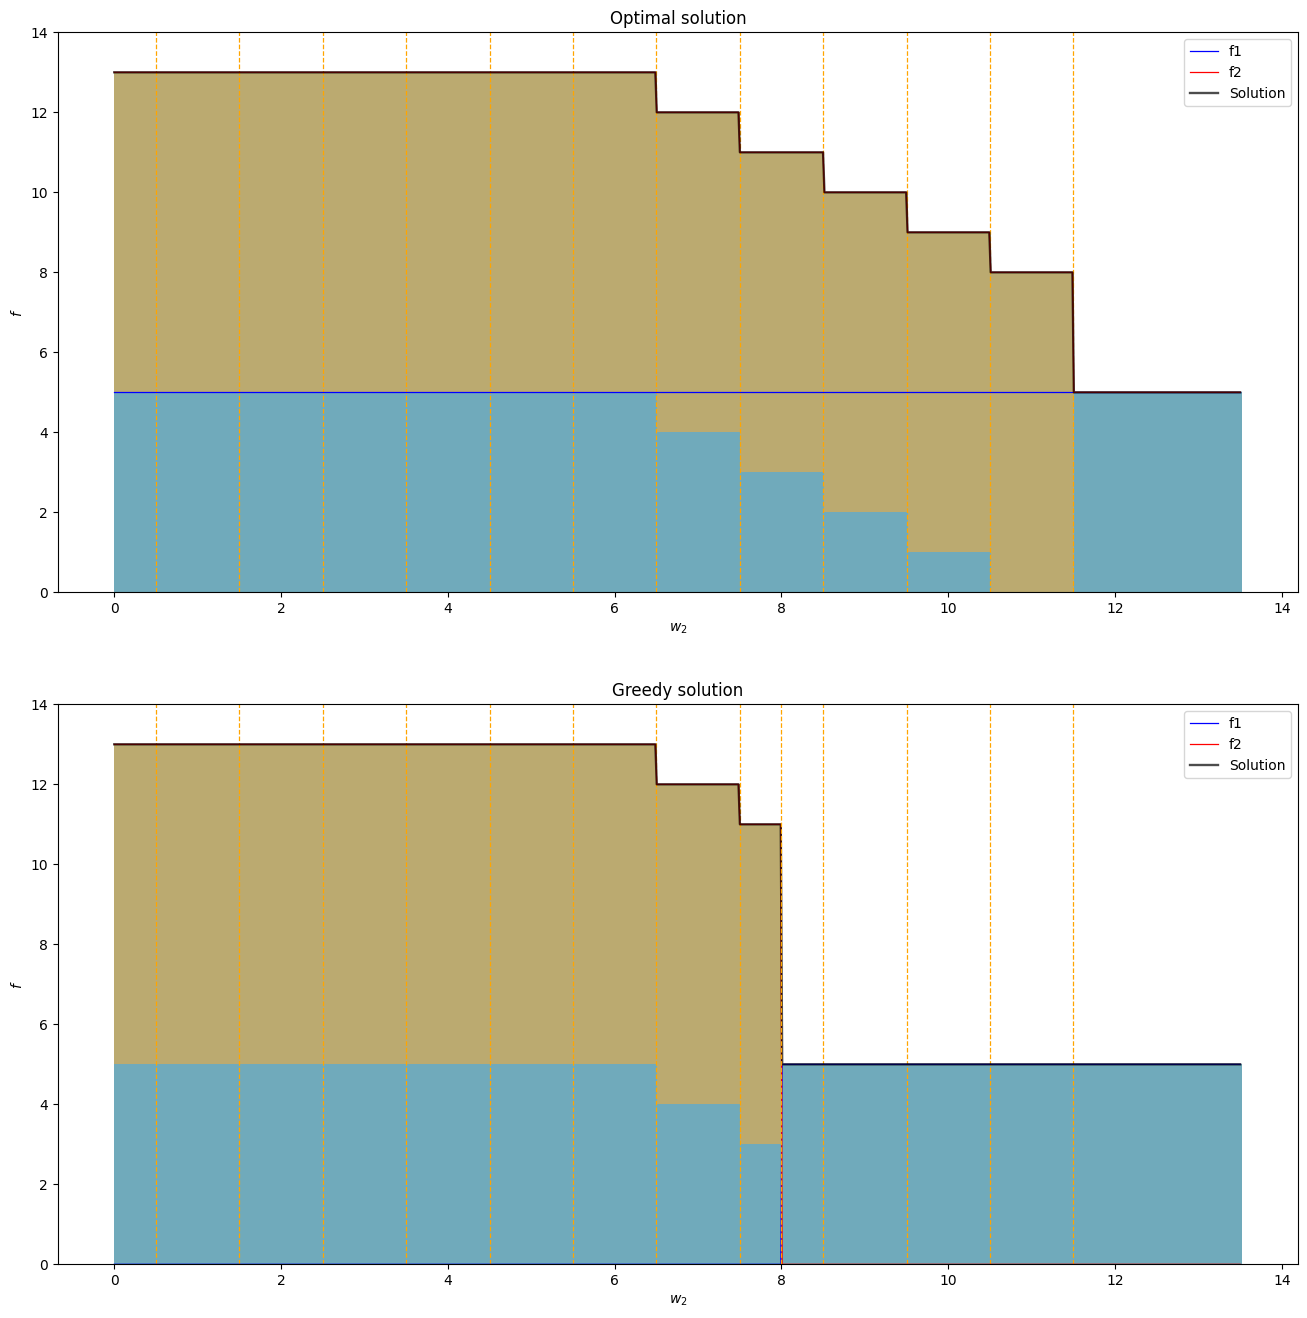

In [23]:
def calc2(w2, **kwargs):
    v1 = kwargs["v1"]
    v2 = kwargs["v2"]
    w1 = np.full_like(w2, kwargs["w1"])
    X1 = kwargs["X1"]
    W = kwargs["W"]

    hsf = (((v1 / w1) - (v2 / w2)) >= 0)

    x1 = hsf * np.minimum(np.floor(W / w1), X1) + (1 - hsf) * np.minimum(np.floor(W / w2), 1)
    x2 = hsf * np.minimum(np.floor((W - w1 * x1) / w2), 1) + (1 - hsf) * np.minimum(np.floor((W - w2 * x1) / w1), X1)
    
    f1 = hsf * (v1 * x1 + v2 * x2)
    f2 = (1 - hsf) * (v2 * x1 + v1 * x2)
    return f1, f2, f1 + f2, hsf * x1 + (1-hsf) * x2, hsf * x2 + (1-hsf) * x1

params = {
    "v1": 1, 
    "v2": 8,
    "w1": 1,
    "X1": 5,
    "W": 11.5,
}

_, ax = plt.subplots(2, 1, figsize=(16,16))
draw_example(params, calc1, ax[0], "Optimal solution")
draw_example(params, calc2, ax[1], "Greedy solution")
ax[1].vlines(
    x=[params["v2"]/params["v1"]*params["w1"]], 
    ymin=0, ymax=14, lw=0.9,
    color='orange', linestyles='dashed'
)
plt.show()

Как мы видим, жадный алгоритм повторяе форму оптимального решения кроме определенного промежутка, где алгоритм, учитывая удельный вес перового предмета, сразу кладёт всё доступное количество из-за чего не остаётся места для второго предмета, хотя пожертвовав несколькими первыми мы могли бы получить результат лучше. Иногда бывает другая ситуация, когда жадник кладет предмет второго типа, но было бы лучше заполнить весь рюкзак предметами первого типа. 

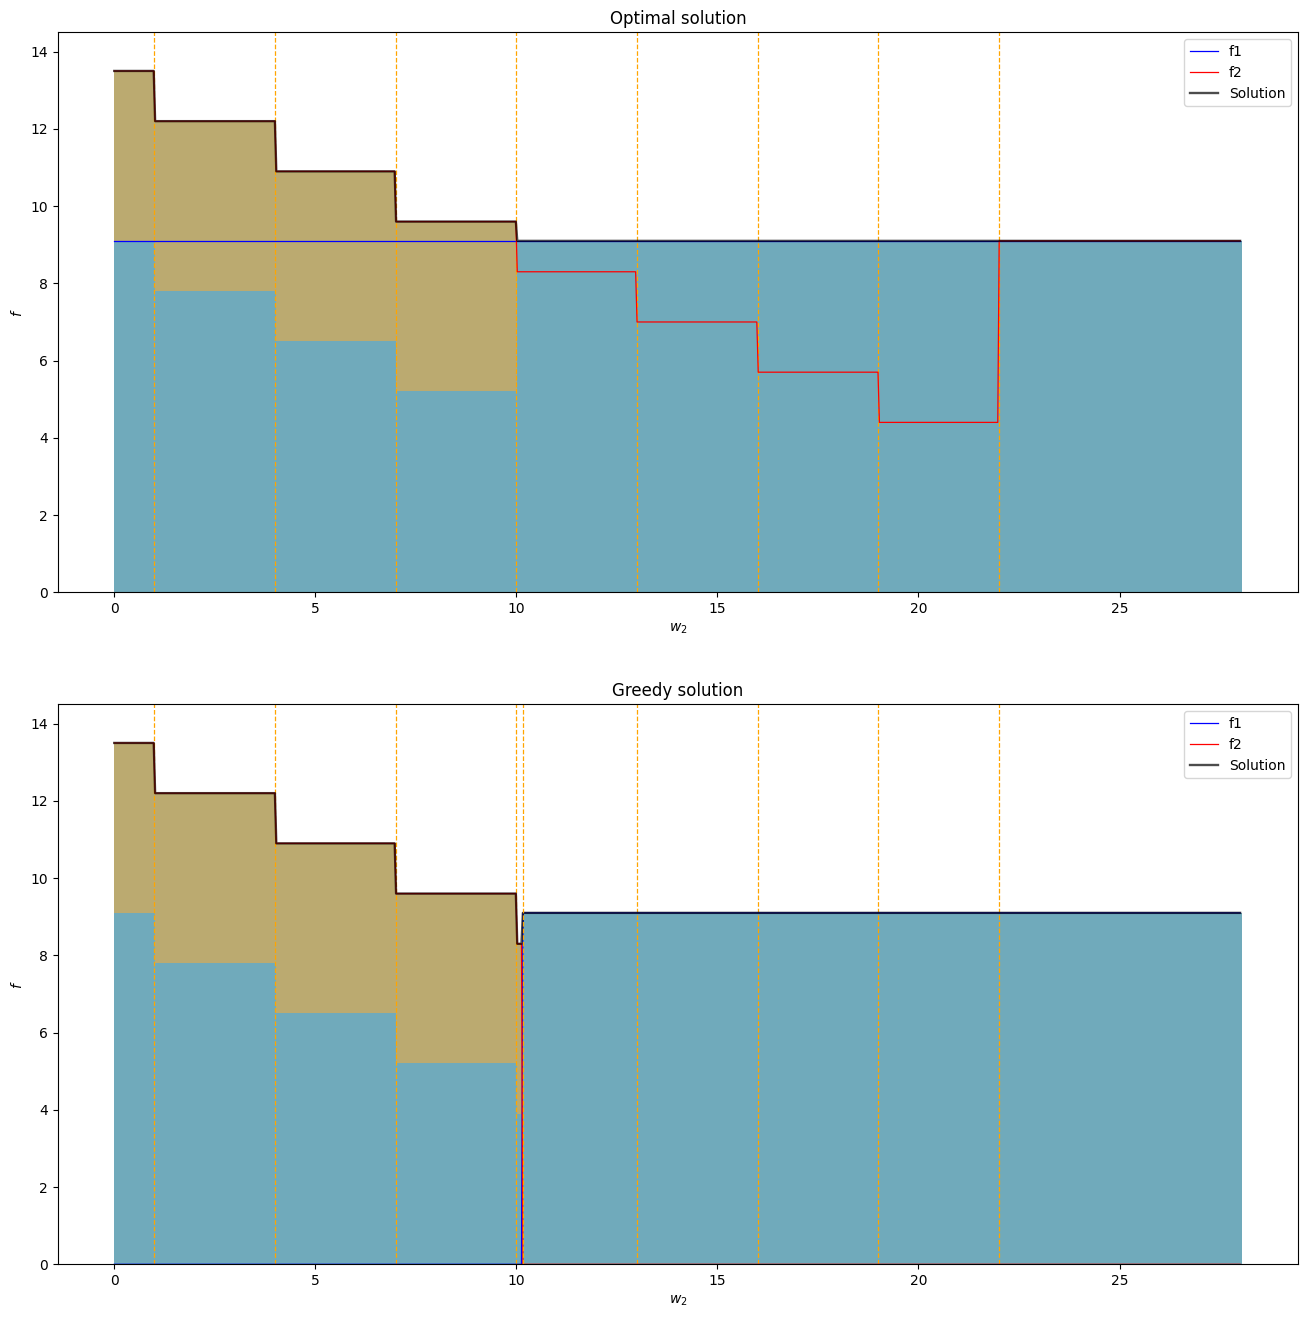

In [24]:
params = {
    "v1": 1.3, 
    "v2": 4.4,
    "w1": 3,
    "X1": 11,
    "W": 22,
}

_, ax = plt.subplots(2, 1, figsize=(16,16))
draw_example(params, calc1, ax[0], "Optimal solution")
draw_example(params, calc2, ax[1], "Greedy solution")
ax[1].vlines(
    x=[params["v2"]/params["v1"]*params["w1"]], 
    ymin=0, ymax=14.5, lw=0.9,
    color='orange', linestyles='dashed'
)
plt.show()

Таким образом получается, что точка $w_2$, когда нам выгодно класть предмет второго типа для аналитического решения является решением уравнения:

$$ v_1 \cdot \min\left(\left\lfloor \frac{W - w_2}{w_1} \right\rfloor, X_1\right) + v_2 = v_1 \cdot \min\left(\left\lfloor \frac{W}{w_1} \right\rfloor, X_1\right)$$

Для жадного же алгоритм эта точка из аргумента функции Хевисайда:

$$ w_2 = \frac{v_2}{v_1}w_1 $$

По сути, если мы условимся, что $X_1$ достаточно велик, т.е. минимум с обоих сторон можно убрать, и вместо целочисленного деления оставить вещественное, то решение первого уравнения будет равно решению для жадного алгоритма. Именно поэтому жадный алгоритм так хорошо решает данную задачу, но из-за упрощений потому и не находит оптимальный максимум в каких-то ситуациях.

## Вывод

В ходе лабораторной работы я решил задачу о рюкзаке с помощью линейного программирования и библиотеки Pyomo, реализовал жадный алгоритм на основе удельной стоимости предметов, а также вывел аналитические решения и проанализировал данные две ситуации для аналитического и жадного алгоритма.